### Imports

In [282]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
import sys
import codecs
import json_lines
import importlib
import json
import urllib
from alphabet_detector import AlphabetDetector
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from langdetect import detect
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

# Data preprocessing

In [283]:
X = []; y = []; z = []

url = "https://www.scss.tcd.ie/doug.leith/CSU44061/2020/reviews_175.jl"
file = urllib.request.urlopen(url)

for line in file:
    decoded_line = line.decode("utf-8")
    item = json.loads(decoded_line)
    X.append(item['text'])
    y.append(item['voted_up'])
    z.append(item['early_access'])

print("Length of the dataset: "+str(len(X)))

Length of the dataset: 5000


## Language Count

Text(0.5, 0, 'languages')

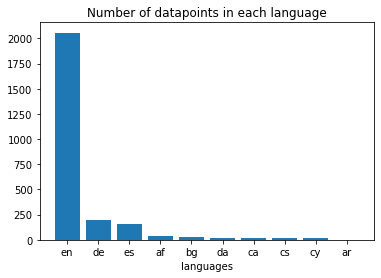

In [284]:
languages = []
for x in X:
    if len(x)>=3: 
            try:
                languages.append(detect(x))
            except:
                continue;

languages = np.array(languages)
unique, counts = np.unique(languages, return_counts=True)

drop_df = pd.DataFrame()
drop_df["languages"] = unique[:10]
drop_df["counts"] = counts[:10]

drop_df.sort_values(by='counts', ascending=False, inplace=True)

fig = plt.figure()
ax = fig.add_subplot()

ax.bar(drop_df.languages, drop_df.counts)
ax.set_title("Number of datapoints in each language")
ax.set_xlabel("languages")

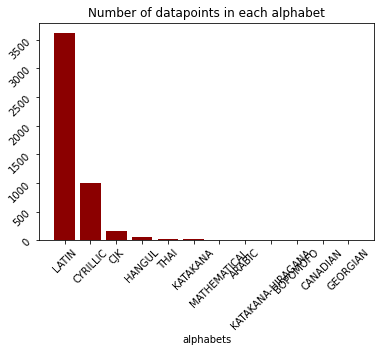

In [285]:
ad = AlphabetDetector()
alphabets = []
for x in X:
    if len(x)>=3: 
            try:
                alph = ad.detect_alphabet(x)
                alphabets.append(list(alph)[0])
            except:
                continue;

alphabets = np.array(alphabets)
unique, counts = np.unique(alphabets, return_counts=True)

drop_df = pd.DataFrame()
drop_df["alphabets"] = unique
drop_df["counts"] = counts

drop_df.sort_values(by='counts', ascending=False, inplace=True)

fig = plt.figure()
ax = fig.add_subplot()

ax.bar(drop_df.alphabets, drop_df.counts, color='darkred')
ax.set_title("Number of datapoints in each alphabet")
ax.set_xlabel("alphabets")
ax.tick_params(rotation=45)

In [286]:
print("Length dataset: "+str(len(X)))

Length dataset: 5000


### Bag of words: Count Vectorizer with stopwords

In [287]:
nltk.download('stopwords')
vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), min_df=5)
X_cv = vectorizer.fit_transform(X)
print("Count Vectorizer with stopwords shape: "+str(X_cv.shape))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janjimenezserra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Count Vectorizer with stopwords shape: (5000, 5229)


### Using TF-IDF 

In [288]:
vectorizer = TfidfVectorizer(min_df=2)
X_tfidf = vectorizer.fit_transform(X)
print("TF-IDF X shape: "+str(X_tfidf.shape))

TF-IDF X shape: (5000, 15363)


### Split into train and test

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Voted Up Predictions

## Naive Bayes

In [290]:
pipesteps = [('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())]
nbModel = Pipeline(pipesteps)
nbModel.fit(X_train, y_train)
predictions = nbModel.predict(X_test)
accuracy = np.mean(predictions == y_test)
print("Accuracy NB: "+str(accuracy*100)+"%")
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("Recall: "+str(tp / (tp+fn)))
print("Specificity: "+str(fp / (tn+fp)))
print("Precision: "+str(tp / (tp+fp)))
print(tn, fp, fn, tp)

Accuracy NB: 71.89999999999999%
Recall: 0.582
Specificity: 0.144
Precision: 0.8016528925619835
428 72 209 291


## SVM Hyperparameter Tuning

Dummy scores: [0.48125 0.50875 0.5075  0.5175  0.4925 ]
Mean dummy score: 0.5015000000000001
Std dummy score : 0.012927683473847883
##################################################
C: 0.1
All scores: [0.73072061 0.71875    0.70527671 0.70471464 0.721598  ]
mean score: 0.7162119909597794
std  score: 0.00997717487108348
mean_scores[i] 0.7162119909597794
std_scores[i] 0.00997717487108348
##################################################
C: 0.2
All scores: [0.7357775  0.72868217 0.71519796 0.71744472 0.72996301]
mean score: 0.7254130700070767
std  score: 0.007831391808630074
mean_scores[i] 0.7254130700070767
std_scores[i] 0.007831391808630074
##################################################
C: 0.3
All scores: [0.73737374 0.73969072 0.72215109 0.72078721 0.7308642 ]
mean score: 0.7301733905548874
std  score: 0.007685825366260976
mean_scores[i] 0.7301733905548874
std_scores[i] 0.007685825366260976
##################################################
C: 0.4
All scores: [0.73989899 0.739018

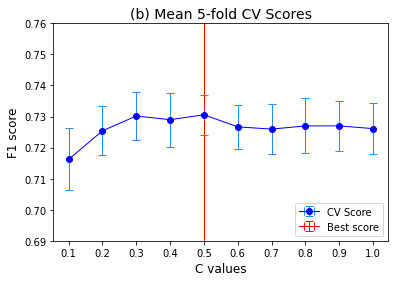

In [291]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 

mean_scores = np.zeros(len(Cs))
std_scores = np.zeros(len(Cs))

scoring = 'f1'
k_cv = 5

dummy_model = DummyClassifier(strategy='uniform')
dummyscores = cross_val_score(dummy_model, X_train, y_train, cv=k_cv) 

print("Dummy scores:", dummyscores)
print("Mean dummy score:", np.mean(dummyscores))
print("Std dummy score :", np.std(dummyscores))


for i, C in enumerate(Cs):   
    print("##################################################")

    print("C:",C)
    pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=C))]
    svmModel = Pipeline(pipesteps)
    svmModel.fit(X_train, y_train)
    
    scores = cross_val_score(svmModel, X_train, y_train, cv=k_cv, scoring=scoring) 

    print("All scores:", scores)
    print("mean score:", np.mean(scores))
    print("std  score:", np.std(scores))

    mean_scores[i] = np.mean(scores)
    print("mean_scores[i]", mean_scores[i])
    std_scores[i] = np.std(scores)
    print("std_scores[i]", std_scores[i])

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(Cs, mean_scores, xerr=0, yerr=std_scores, 
            label='CV Score', fmt='-o', color='blue', ecolor='dodgerblue', lw=1, capsize=4);

#ds_array = np.repeat(np.mean(dummyscores), len(Cs))
#ax.errorbar(Cs, ds_array, xerr=0, yerr=np.std(dummyscores), 
#            label='Dummy CV Score', fmt='-o', color='lightblue', ecolor='lightblue', lw=1, capsize=4);

ax.errorbar(0.5, 0.70, xerr=0, yerr=0.40, 
            label='Best score', ls='-', color='red', ecolor='red', lw=1, capsize=4);

ax.set_title("(b) Mean 5-fold CV Scores", fontsize=14)
ax.set_xlabel("C values", fontsize=12)
ax.set_ylabel("F1 score", fontsize=12)
ax.set_xticks(Cs)
plt.ylim(0.69, 0.76)
plt.legend(loc='lower right')

## SVM Results

In [292]:
pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=0.5))]
svmModel = Pipeline(pipesteps)

svmModel.fit(X_train, y_train)
predictions = svmModel.predict(X_test)
accuracy = np.mean(predictions == y_test)
print("Accuracy SVM: "+str(accuracy*100)+"%")

Accuracy SVM: 73.9%


In [293]:
len(y_test)

1000

#### Confusion Matrix

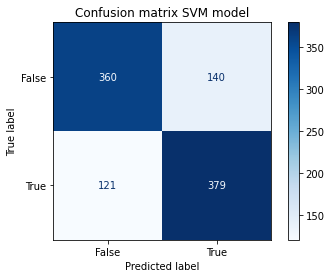

In [294]:
plot_confusion_matrix(svmModel, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix SVM model")
plt.grid(False)
plt.show()

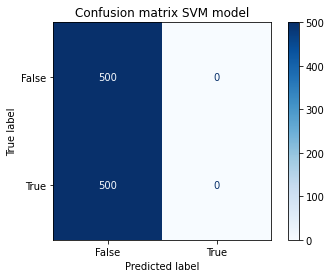

In [295]:
plot_confusion_matrix(DummyClassifier(strategy='most_frequent').fit(X_train, y_train), X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix SVM model")
plt.grid(False)
plt.show()

## KNN

Dummy scores: [0.485   0.50375 0.47625 0.5025  0.4575 ]
Mean dummy score: 0.485
Std dummy score : 0.017266296649831998
##################################################
Number of neighbors: 3
All scores: [0.67581475 0.30578512 0.32510288 0.32786885 0.33400402]
mean score: 0.39371512650314267
std  score: 0.14136525137323358
p = 1 mean_scores[i] 0.39371512650314267
p = 1 std_scores[i] 0.14136525137323358
##################################################
Number of neighbors: 5
All scores: [0.61065574 0.65498155 0.64869888 0.63495146 0.57696693]
mean score: 0.625250912262932
std  score: 0.028538327136081322
p = 1 mean_scores[i] 0.625250912262932
p = 1 std_scores[i] 0.028538327136081322
##################################################
Number of neighbors: 10
All scores: [0.60759494 0.65009208 0.6447985  0.59796149 0.54347826]
mean score: 0.6087850547964149
std  score: 0.038436393817241774
p = 1 mean_scores[i] 0.6087850547964149
p = 1 std_scores[i] 0.038436393817241774
##################

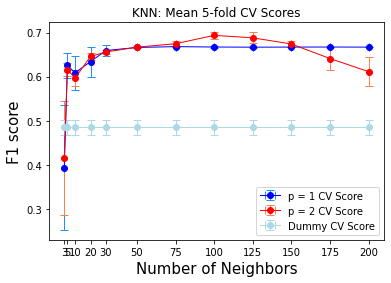

In [296]:
n_neighbors = [3, 5, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200] 
ps = [1, 2]

mean_scores_1 = np.zeros(len(n_neighbors))
std_scores_1 = np.zeros(len(n_neighbors))

mean_scores_2 = np.zeros(len(n_neighbors))
std_scores_2 = np.zeros(len(n_neighbors))

scoring = 'f1'
k_cv = 5

dummy_model = DummyClassifier(strategy='uniform')
dummyscores = cross_val_score(dummy_model, X_train, y_train, cv=k_cv) 

print("Dummy scores:", dummyscores)
print("Mean dummy score:", np.mean(dummyscores))
print("Std dummy score :", np.std(dummyscores))

for p in ps: 
    for i, n in enumerate(n_neighbors):   
        print("##################################################")

        print("Number of neighbors:",n)
        pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', KNeighborsClassifier(n_neighbors=n, p=p))]
        svmModel = Pipeline(pipesteps)
        svmModel.fit(X_train, y_train)

        scores = cross_val_score(svmModel, X_train, y_train, cv=k_cv, scoring=scoring) 

        print("All scores:", scores)
        print("mean score:", np.mean(scores))
        print("std  score:", np.std(scores))

        if p == 1:
            mean_scores_1[i] = np.mean(scores)
            print("p = 1 mean_scores[i]", mean_scores_1[i])
            std_scores_1[i] = np.std(scores)
            print("p = 1 std_scores[i]", std_scores_1[i])
        else:
            mean_scores_2[i] = np.mean(scores)
            print("p = 2 mean_scores[i]", mean_scores_2[i])
            std_scores_2[i] = np.std(scores)
            print("p = 2 std_scores[i]", std_scores_2[i])

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(n_neighbors, mean_scores_1, xerr=0, yerr=std_scores_1, 
            label='p = 1 CV Score', fmt='-o', color='blue', ecolor='dodgerblue', lw=1, capsize=4);

ax.errorbar(n_neighbors, mean_scores_2, xerr=0, yerr=std_scores_2, 
            label='p = 2 CV Score', fmt='-o', color='red', ecolor='coral', lw=1, capsize=4);

ds_array = np.repeat(np.mean(dummyscores), len(n_neighbors))
ax.errorbar(n_neighbors, ds_array, xerr=0, yerr=np.std(dummyscores), 
            label='Dummy CV Score', fmt='-o', color='lightblue', ecolor='lightblue', lw=1, capsize=4);

#ax.errorbar(0.5, 0.70, xerr=0, yerr=0.40, 
            #label='Best score', ls='-', color='red', ecolor='red', lw=1, capsize=4);

ax.set_title("KNN: Mean 5-fold CV Scores")
ax.set_xlabel("Number of Neighbors", fontsize=15)
ax.set_ylabel("F1 score", fontsize=15)
ax.set_xticks(n_neighbors)
#plt.ylim(0.66, 0.74)
plt.legend(loc='lower right')

In [297]:
pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', KNeighborsClassifier(n_neighbors=100, p=2))]
knnModel = Pipeline(pipesteps)

knnModel.fit(X_train, y_train)
predictions = knnModel.predict(X_test)
accuracy = np.mean(predictions == y_test)
print("Accuracy KNN: "+str(accuracy*100)+"%")

Accuracy KNN: 52.800000000000004%


## ROC Curve

Text(0.5, 0.98, 'ROC curve comparison')

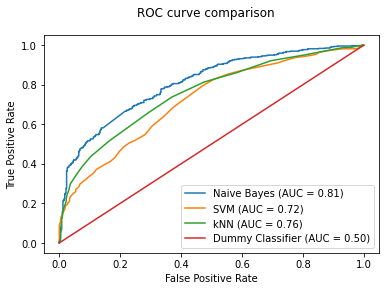

In [298]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)

nb_disp = plot_roc_curve(nbModel, X_test, y_test, name="Naive Bayes") 
svm_disp = plot_roc_curve(svmModel, X_test, y_test, name="SVM", ax=nb_disp.ax_)
knn_disp = plot_roc_curve(knnModel, X_test, y_test, name="kNN", ax=svm_disp.ax_)
disp = plot_roc_curve(dummy_model, X_test, y_test, name="Dummy Classifier", ax=knn_disp.ax_)
disp.figure_.suptitle("ROC curve comparison")

# Early Access

### Split into train and test

In [299]:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

### Naive Bayes

In [300]:
n_earlyaccess = 0
for i in z_test:
    if i == 1:
        n_earlyaccess += 1
n_earlyaccess

104

1000
Accuracy NB: 89.60000000000001%
Recall: 0.0
Specificity: 0.0
Precision: nan
896 0 104 0


<ipython-input-301-067c115d6ad0>:16: RuntimeWarning: invalid value encountered in long_scalars
  print("Precision: "+str(tp / (tp+fp)))


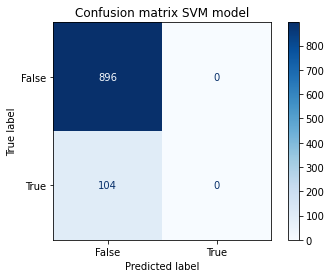

In [301]:
pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())]
nbModel = Pipeline(pipesteps)
nbModel.fit(X_train, z_train)
predictions = nbModel.predict(X_test)

n_earlyaccess = 0
for i in predictions:
    n_earlyaccess += 1
print(n_earlyaccess)

accuracy = np.mean(predictions == z_test)
print("Accuracy NB: "+str(accuracy*100)+"%")
tn, fp, fn, tp = confusion_matrix(z_test, predictions).ravel()
print("Recall: "+str(tp / (tp+fn)))
print("Specificity: "+str(fp / (tn+fp)))
print("Precision: "+str(tp / (tp+fp)))
print(tn, fp, fn, tp)

plot_confusion_matrix(nbModel, X_test, z_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix SVM model")
plt.grid(False)
plt.show()

### SVM

Dummy scores: [0. 0. 0. 0. 0.]
Mean dummy score: 0.0
Std dummy score : 0.0
##################################################
C: 1
All scores: [0.09345794 0.19047619 0.12244898 0.10309278 0.08247423]
mean score: 0.11839002486050784
std  score: 0.03836260989441818
mean_scores[i] 0.11839002486050784
std_scores[i] 0.03836260989441818
##################################################
C: 2
All scores: [0.14159292 0.2037037  0.16666667 0.13461538 0.0952381 ]
mean score: 0.1483633541155665
std  score: 0.03592966493686456
mean_scores[i] 0.1483633541155665
std_scores[i] 0.03592966493686456
##################################################
C: 5
All scores: [0.20967742 0.20689655 0.18803419 0.12173913 0.10526316]
mean score: 0.16632208948853683
std  score: 0.04407543579397761
mean_scores[i] 0.16632208948853683
std_scores[i] 0.04407543579397761
##################################################
C: 10
All scores: [0.23622047 0.24793388 0.17886179 0.1147541  0.11864407]
mean score: 0.1792828623027

/Users/janjimenezserra/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/janjimenezserra/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


All scores: [0.20143885 0.22047244 0.23448276 0.12030075 0.13953488]
mean score: 0.18324593681741286
std  score: 0.045199024410939606
mean_scores[i] 0.18324593681741286
std_scores[i] 0.045199024410939606
##################################################
C: 100


/Users/janjimenezserra/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


All scores: [0.22068966 0.23880597 0.22222222 0.13333333 0.13432836]
mean score: 0.18987590781723565
std  score: 0.046200681982460336
mean_scores[i] 0.18987590781723565
std_scores[i] 0.046200681982460336


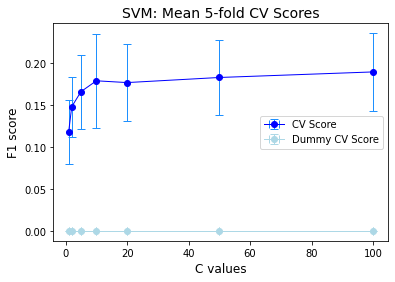

In [302]:
Cs = [1, 2, 5, 10, 20, 50, 100]

mean_scores = np.zeros(len(Cs))
std_scores = np.zeros(len(Cs))

scoring = 'f1'
k_cv = 5

dummy_model = DummyClassifier(strategy='most_frequent')
dummyscores = cross_val_score(dummy_model, X_train, z_train, cv=k_cv, scoring=scoring) 

print("Dummy scores:", dummyscores)
print("Mean dummy score:", np.mean(dummyscores))
print("Std dummy score :", np.std(dummyscores))


for i, C in enumerate(Cs):   
    print("##################################################")

    print("C:",C)
    pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=C))]
    svmModel = Pipeline(pipesteps)
    svmModel.fit(X_train, z_train)
    
    scores = cross_val_score(svmModel, X_train, z_train, cv=k_cv, scoring=scoring) 

    print("All scores:", scores)
    print("mean score:", np.mean(scores))
    print("std  score:", np.std(scores))

    mean_scores[i] = np.mean(scores)
    print("mean_scores[i]", mean_scores[i])
    std_scores[i] = np.std(scores)
    print("std_scores[i]", std_scores[i])

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(Cs, mean_scores, xerr=0, yerr=std_scores, 
            label='CV Score', fmt='-o', color='blue', ecolor='dodgerblue', lw=1, capsize=4);

#ax.errorbar(0.5, 0.70, xerr=0, yerr=0.40, 
#            label='Best score', ls='-', color='red', ecolor='red', lw=1, capsize=4);
    
ds_array = np.repeat(np.mean(dummyscores), len(Cs))
ax.errorbar(Cs, ds_array, xerr=0, yerr=np.std(dummyscores), 
           label='Dummy CV Score', fmt='-o', color='lightblue', ecolor='lightblue', lw=1, capsize=4);

ax.set_title("SVM: Mean 5-fold CV Scores", fontsize=14)
ax.set_xlabel("C values", fontsize=12)
ax.set_ylabel("F1 score", fontsize=12)
#ax.set_xticks(Cs)
#plt.ylim(0.66, 0.74)
plt.legend(loc='center right')

In [303]:
pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=10))]
svmModel = Pipeline(pipesteps)

svmModel.fit(X_train, z_train)
predictions = svmModel.predict(X_test)
accuracy = np.mean(predictions == z_test)
print("Accuracy SVM: "+str(accuracy*100)+"%")

Accuracy SVM: 87.0%


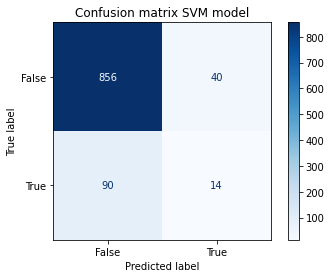

In [304]:
plot_confusion_matrix(svmModel, X_test, z_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix SVM model")
plt.grid(False)
plt.show()

## Languages of early access

48.7758945386064


Text(0.5, 0, 'languages')

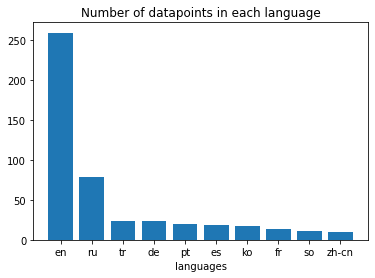

In [305]:
languages = []
for i, x in enumerate(X):
    if len(x)>=3 and z[i]==1: 
            try:
                languages.append(detect(x))
            except:
                continue;

x = np.array(languages)
unique, counts = np.unique(x, return_counts=True)

drop_df = pd.DataFrame()
drop_df["languages"] = unique
drop_df["counts"] = counts

drop_df.sort_values(by='counts', ascending=False, inplace=True)

fig = plt.figure()
ax = fig.add_subplot()
ax.bar(drop_df.languages[:10], drop_df.counts[:10])

count = 0
for i in drop_df.counts:
    count += i

maxnum = np.max(counts)


print((maxnum * 100) / count)

ax.set_title("Number of datapoints in each language")
ax.set_xlabel("languages")

## KNN

Dummy scores: [0. 0. 0. 0. 0.]
Mean dummy score: 0.0
Std dummy score : 0.0
##################################################
Number of neighbors: 2
All scores: [0. 0. 0. 0. 0.]
mean score: 0.0
std  score: 0.0
p = 1 mean_scores[i] 0.0
p = 1 std_scores[i] 0.0
##################################################
Number of neighbors: 10
All scores: [0. 0. 0. 0. 0.]
mean score: 0.0
std  score: 0.0
p = 1 mean_scores[i] 0.0
p = 1 std_scores[i] 0.0
##################################################
Number of neighbors: 100
All scores: [0. 0. 0. 0. 0.]
mean score: 0.0
std  score: 0.0
p = 1 mean_scores[i] 0.0
p = 1 std_scores[i] 0.0
##################################################
Number of neighbors: 500
All scores: [0. 0. 0. 0. 0.]
mean score: 0.0
std  score: 0.0
p = 1 mean_scores[i] 0.0
p = 1 std_scores[i] 0.0
##################################################
Number of neighbors: 1000
All scores: [0. 0. 0. 0. 0.]
mean score: 0.0
std  score: 0.0
p = 1 mean_scores[i] 0.0
p = 1 std_scores[i] 0

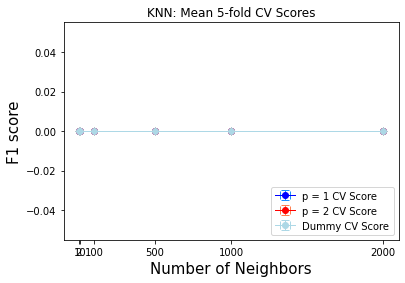

In [306]:
n_neighbors = [2, 10, 100, 500, 1000, 2000] 
ps = [1, 2]

mean_scores_1 = np.zeros(len(n_neighbors))
std_scores_1 = np.zeros(len(n_neighbors))

mean_scores_2 = np.zeros(len(n_neighbors))
std_scores_2 = np.zeros(len(n_neighbors))

scoring = 'f1'
k_cv = 5

dummy_model = DummyClassifier(strategy='most_frequent')
dummyscores = cross_val_score(dummy_model, X_train, z_train, cv=k_cv, scoring=scoring) 

print("Dummy scores:", dummyscores)
print("Mean dummy score:", np.mean(dummyscores))
print("Std dummy score :", np.std(dummyscores))

for p in ps: 
    for i, n in enumerate(n_neighbors):   
        print("##################################################")

        print("Number of neighbors:",n)
        pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', KNeighborsClassifier(n_neighbors=n, p=p))]
        svmModel = Pipeline(pipesteps)
        svmModel.fit(X_train, z_train)

        scores = cross_val_score(svmModel, X_train, z_train, cv=k_cv, scoring=scoring) 

        print("All scores:", scores)
        print("mean score:", np.mean(scores))
        print("std  score:", np.std(scores))

        if p == 1:
            mean_scores_1[i] = np.mean(scores)
            print("p = 1 mean_scores[i]", mean_scores_1[i])
            std_scores_1[i] = np.std(scores)
            print("p = 1 std_scores[i]", std_scores_1[i])
        else:
            mean_scores_2[i] = np.mean(scores)
            print("p = 2 mean_scores[i]", mean_scores_2[i])
            std_scores_2[i] = np.std(scores)
            print("p = 2 std_scores[i]", std_scores_2[i])

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(n_neighbors, mean_scores_1, xerr=0, yerr=std_scores_1, 
            label='p = 1 CV Score', fmt='-o', color='blue', ecolor='dodgerblue', lw=1, capsize=4);

ax.errorbar(n_neighbors, mean_scores_2, xerr=0, yerr=std_scores_2, 
            label='p = 2 CV Score', fmt='-o', color='red', ecolor='coral', lw=1, capsize=4);

ds_array = np.repeat(np.mean(dummyscores), len(n_neighbors))
ax.errorbar(n_neighbors, ds_array, xerr=0, yerr=np.std(dummyscores), 
            label='Dummy CV Score', fmt='-o', color='lightblue', ecolor='lightblue', lw=1, capsize=4);

#ax.errorbar(0.5, 0.70, xerr=0, yerr=0.40, 
            #label='Best score', ls='-', color='red', ecolor='red', lw=1, capsize=4);

ax.set_title("KNN: Mean 5-fold CV Scores")
ax.set_xlabel("Number of Neighbors", fontsize=15)
ax.set_ylabel("F1 score", fontsize=15)
ax.set_xticks(n_neighbors)
#plt.ylim(0.66, 0.74)
plt.legend(loc='lower right')

1000
Accuracy KNN: 89.5%
Recall: 0.0
Specificity: 0.0011160714285714285
Precision: 0.0
895 1 104 0


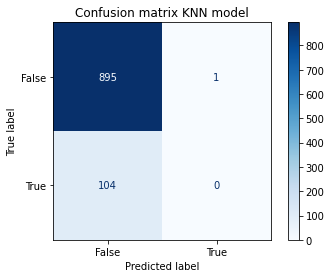

In [307]:
pipesteps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', KNeighborsClassifier(n_neighbors=3, p=2))]
knnModel = Pipeline(pipesteps)
knnModel.fit(X_train, z_train)
predictions = knnModel.predict(X_test)

n_earlyaccess = 0
for i in predictions:
    n_earlyaccess += 1
print(n_earlyaccess)

accuracy = np.mean(predictions == z_test)
print("Accuracy KNN: "+str(accuracy*100)+"%")
tn, fp, fn, tp = confusion_matrix(z_test, predictions).ravel()
print("Recall: "+str(tp / (tp+fn)))
print("Specificity: "+str(fp / (tn+fp)))
print("Precision: "+str(tp / (tp+fp)))
print(tn, fp, fn, tp)

plot_confusion_matrix(knnModel, X_test, z_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix KNN model")
plt.grid(False)
plt.show()

Text(0.5, 0.98, 'ROC curve comparison')

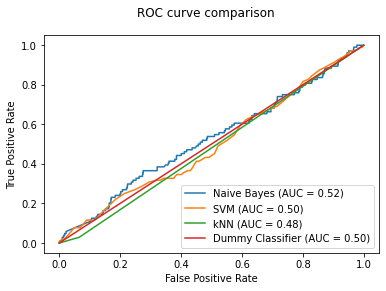

In [308]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, z_train)

nb_disp = plot_roc_curve(nbModel, X_test, z_test, name="Naive Bayes") 
svm_disp = plot_roc_curve(svmModel, X_test, z_test, name="SVM", ax=nb_disp.ax_)
knn_disp = plot_roc_curve(knnModel, X_test, z_test, name="kNN", ax=svm_disp.ax_)
disp = plot_roc_curve(dummy_model, X_test, z_test, name="Dummy Classifier", ax=knn_disp.ax_)
disp.figure_.suptitle("ROC curve comparison")